In [71]:
#Can we get plots of first betas?
#Shows each individual plot along with which model best fits it
import pickle, math
import pandas as pd
import sqlite3
import random
import os
import itertools
exec(open('Imports.py').read()) #execfile('Imports.py')
exec(open('ImportModels.py').read())
import Modules.Funcs as funcs
# from Modules.Classes import Simulation
# from Modules.Classes import CopyTweak
# from Modules.Classes import CopyTweakRep
# from Modules.Classes import Packer
# from Modules.Classes import PackerRep
# from Modules.Classes import PackerEuc
# from Modules.Classes import ConjugateJK13
# from Modules.Classes import RepresentJK13
from scipy.stats import stats as ss
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

#plotting options
STAT_LIMS =  (-1.0, 1.0)
#Fit to only last trial?
fitlast = False
#Make plots?
doplots = True
saveplots = True
if fitlast:
    showlast = True
else:
    showlast = False #True = Show last even if fitting to all?
#Bootstrap parameters
nbootstraps = 1000

#Some plotting options
font = {'family' : 'DejaVu Sans',
        'weight' : 'regular',
        'size'   : 15}

#Specify simulation values
N_SAMPLES = 10000
WT_THETA = 1.5
MIN_LL = 1e-10

# Specify default dataname
dbname = 'experiment-corner.db'#'experiments-5con.db'#raw data
dataname_def = 'corner'#'5con'#bestparms comes from here

# Specify default dataname
# dataname_def = 'pooled'#'nosofsky1986'#'NGPMG1994'
participant_def = 'all'
unique_trials_def = 'all'
dataname = dataname_def
execfile('validate_data.py')

bestparmdb = "pickles/chtc_gs_best_params_{}".format(src)


plt.rc('font', **font)

# get data from pickle
with open(pickledir+src, "rb" ) as f:
    trials = pickle.load( f )

with open(bestparmdb, "rb" ) as f:
    best_params_t = pickle.load( f )

#Rebuild parms into a smaller dict
best_params = dict()
for modelname in best_params_t.keys():    
    best_params[modelname] = dict()
    for i,parmname in enumerate(best_params_t[modelname]['parmnames']):
        parmval = best_params_t[modelname]['bestparmsll']
        best_params[modelname][parmname] = parmval[i]
modelList = [Packer,RepresentJK13]
#modelList = [CopyTweak,CopyTweakRep,Packer, RepresentJK13,]                            

#Specify plot order
modelPlotOrder = np.array([[Packer,RepresentJK13],[CopyTweak,ConjugateJK13]])
     
unique_trials = 'all'
trials.task = task

#Create new trialset
con = sqlite3.connect(dbname)
participants = pd.read_sql_query("SELECT participant, condition from participants", con)
generation = pd.read_sql_query("SELECT * from generation", con)
alphas = pd.read_sql_query("SELECT * from alphas", con)
stimuli = pd.read_sql_query("SELECT * from stimuli", con).values
con.close()





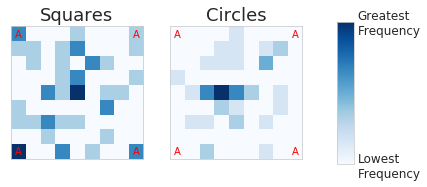

In [72]:
firsts = []
firsts += [generation.loc[(generation.wrap_ax!=1.0) & (generation.trial==0),'stimulus']] #Squares
firsts += [generation.loc[(generation.wrap_ax==1.0) & (generation.trial==0),'stimulus']] #Circles
#Convert to ps
ps = []
f,ax = plt.subplots(1,len(firsts),figsize=(3*len(firsts),3))
A = alphas.Corner_C.values
As = stimuli[A]
titles = ['Squares','Circles']
for i,first in enumerate(firsts):
    freq = first.value_counts(normalize=True,sort=False).sort_index()
    p = np.zeros(len(stimuli))
    p[freq.keys()] = freq.values
    ps += [p]    
    gps = funcs.gradientroll(p,'roll')[:,:,0]
    ps_ElRange = gps.max()-gps.min();
    plotVals = (gps-gps.min())/ps_ElRange
    gammas = []
    im = funcs.plotgradient(ax[i], plotVals, As, [], gammas = gammas,clim = [0,1], cmap = 'Blues',beta_col='green')
    ax[i].set_title(titles[i])
# add colorbar
f.subplots_adjust(right=0.8)
cbar = f.add_axes([0.88, 0.17, 0.04, 0.66])
cb = f.colorbar(im, cax=cbar, ticks = [0,1])#,boundaries=np.unique(plotVals))
cbar.set_yticklabels(['Lowest\nFrequency', 'Greatest\nFrequency'],fontsize=12)
# cb = f.colorbar(im, cax=cbar, ticks = np.unique(plotVals),boundaries=np.unique(plotVals))
# cbar.set_yticklabels(range(6),fontsize=10)
cbar.tick_params(length = 0)

if saveplots:
    plt.savefig('private/firstbetas_cornerbehav.pdf',bbox_inches='tight')

In [85]:
print(max(ps[0][outind]))
print(max(ps[0][innind]))

print(max(ps[1][outind]))
print(max(ps[1][innind]))



0.06521739130434782
0.06521739130434782
0.046511627906976744
0.13953488372093023


In [82]:
outind

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 18,
 27,
 36,
 45,
 54,
 63,
 17,
 26,
 35,
 44,
 53,
 62,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80]

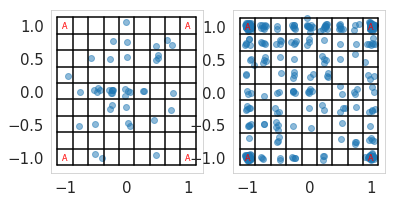

In [47]:
firsts = []
firsts += [generation.loc[(generation.wrap_ax==1.0) & (generation.trial==0),'stimulus']] #Circles
firsts += [generation.loc[(generation.wrap_ax!=1.0) & (generation.trial==0),'stimulus']] #Squares
#Convert to ps
ps = []
f,ax = plt.subplots(1,len(firsts),figsize=(3*len(firsts),3))
A = alphas.Corner_C.values
As = stimuli[A]
step = .25
adj = - step/2
for i,first in enumerate(firsts):
    stimvals = stimuli[first]
    #Add jitter
    stimvals = funcs.jitterize(stimvals,sd=.03)
    ax[i].scatter(stimvals[:,0],stimvals[:,1],alpha=.5)
    stepx = np.unique(stimuli[:,0]) + adj
    stepy = np.unique(stimuli[:,1]) + adj
    stepx = np.append(stepx,max(stepx)+step)
    stepy = np.append(stepy,max(stepy)+step)
    for pi,xx in enumerate(stepx):
        ax[i].grid(False)
        ax[i].plot([xx,xx],[min(stepy),max(stepy)],'k-')        
        ax[i].plot([min(stepx),max(stepx)],[xx,xx],'k-')
        for AsEl in As:
            ax[i].text(AsEl[0],AsEl[1],'A',color='red',
                       horizontalalignment='center',verticalalignment='center',
                      alpha=.15,
                      fontsize=8)


{'category_variance_bias': 4.0706961282242596e+20, 'determinism': 0.725392401354471, 'category_mean_bias': 1.0014877864883311e-10, 'domain_variance_bias': 0.13740177759888955}
Outer edges: 0.45
Inner spaces: 0.55


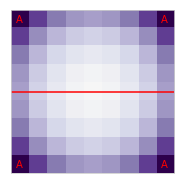

In [48]:
##Probabilities at outer edge vs inner space - Rep
steps = 9
vals = np.linspace(-1, 1,steps).tolist()
space = np.fliplr(funcs.cartesian([vals, vals]))
st = 2./(steps-1)

wrap_ax=None
outind = range(steps) + [(e+1)*steps for e in range(steps-2)] + [(e+1)*steps+steps-1 for e in range(steps-2)] + range(steps**2-steps,steps**2)
innind = [i for i in range(steps**2) if not i in outind]
model = RepresentJK13
params = best_params[model.model]
# params['category_mean_bias']=0
categories1 = [np.array([[-1.,-1.],[1.,-1.],[-1.,1.],[1.,1.]])]

# categories1 = [np.array([[-1,-1],[1,-1],[-1,1],[1,1]])]

# categories1 = [np.array([[-1,-.5],[1,-.5],[-1,-.75],[1,-.75]])]
temp1 = model(categories1,params,wrap_ax=wrap_ax,stimstep=[st,st]).get_generation_ps(space,1,'generate')
outps = sum(temp1[outind])
innps = sum(temp1[innind])
# print(np.round(np.reshape(temp1,(9,9)),3))
print(params)
print('Outer edges: ' + str(np.round(outps,2)))
print('Inner spaces: ' + str(np.round(innps,2)))
temp11= np.reshape(temp1,(steps,steps))
midtemp = (steps+1)/2 - 1
oneup = temp11[midtemp+1][0]
onedn = temp11[midtemp-1][0]
# print(oneup)
# print(onedn)
# print(oneup-onedn)
f,ax = plt.subplots(1,1,figsize=(3,3))
gps = funcs.gradientroll(temp1,'roll')[:,:,0]
ps_ElRange = gps.max()-gps.min();
plotVals = (gps-gps.min())/ps_ElRange
gammas = []
funcs.plotgradient(ax, plotVals, categories1[0], [], gammas = gammas,clim = STAT_LIMS, cmap = 'PuOr',beta_col='green')
xlim = ax.get_xlim()
ylim = ax.get_ylim()
yhalf = np.mean(ylim)
ax.plot(xlim,[yhalf,yhalf],'r-')

PACKER - Outer edges: 0.34, Max: 0.0119
PACKER - Inner spaces: 0.66, Max: 0.0154
Representative - Outer edges: 0.45, Max: 0.0163
Representative - Inner spaces: 0.55, Max: 0.0132
PACKER - Outer edges: 0.29, Max: 0.0146
PACKER - Inner spaces: 0.71, Max: 0.0188
Max wrapped axis reached.
Max wrapped axis reached.
Representative - Outer edges: 0.3, Max: 0.0438
Representative - Inner spaces: 0.7, Max: 0.0394


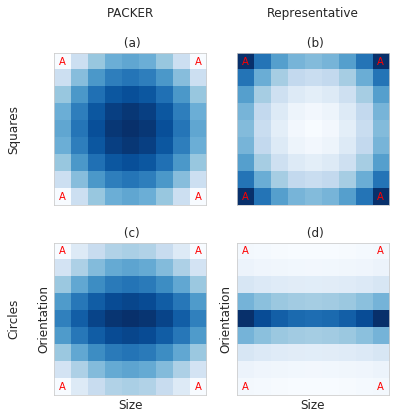

In [96]:
# Probabilities at outer edge vs inner space - Rep

steps = 9
vals = np.linspace(-1, 1,steps).tolist()
space = np.fliplr(funcs.cartesian([vals, vals]))
st = 2./(steps-1)

models = [Packer,RepresentJK13]
f,ax = plt.subplots(2,len(models),figsize=(6,3.2*len(models)))
wraps = [None,1]
labels = [['a','b'],['c','d']]
for wi,wrap_ax in enumerate(wraps):
    for mi,model in enumerate(models):
        outind = range(steps) + [(e+1)*steps for e in range(steps-2)] + [(e+1)*steps+steps-1 for e in range(steps-2)] + range(steps**2-steps,steps**2)        
        innind = [i for i in range(steps**2) if not i in outind]
        params = best_params[model.model]
        categories1 = [np.array([[-1.,-1.],[1.,-1.],[-1.,1.],[1.,1.]])]
        temp1 = model(categories1,params,wrap_ax=wrap_ax).get_generation_ps(space,1,'generate')
        outps = sum(temp1[outind])
        innps = sum(temp1[innind])
        maxout = max(temp1[outind])
        maxin = max(temp1[innind])
        print('{} - Outer edges: {}, Max: {}'.format(model.modelshort,np.round(outps,2),np.round(maxout,4)))
        print('{} - Inner spaces: {}, Max: {}'.format(model.modelshort, np.round(innps,2),np.round(maxin,4)))
        gps = funcs.gradientroll(temp1,'roll')[:,:,0]
        ps_ElRange = gps.max()-gps.min();
        plotVals = (gps-gps.min())/ps_ElRange
        gammas = []
#         categories1[0] = [[-.9,-.9],[-.9,.9],[.9,-.9],[.9,.9]]
        funcs.plotgradient(ax[wi,mi], plotVals, categories1[0], [], gammas = gammas,clim = [0,1], cmap = 'Blues',beta_col='green')
        if wi==0:
            modeln = model.modelshort 
            if mi==0:
                ax[wi,mi].set_ylabel('Squares\n\n',fontsize=12)
        else:
            modeln = ''
            if mi==0:
                ax[wi,mi].set_ylabel('Circles\n\nOrientation',fontsize=12)
            else:
                ax[wi,mi].set_ylabel('Orientation',fontsize=12)
            ax[wi,mi].set_xlabel('Size',fontsize=12)
        
        #titlestr = '%s\nOuter edges: %.2f \nInner spaces: %.2f' % (modeln,outps,innps)
        titlestr = '%s\n\n (%s)'% (modeln,labels[wi][mi])
        ax[wi,mi].set_title(titlestr,fontsize=12)
        
if saveplots:
    plt.savefig('private/firstbetas_cornerPostfits.pdf',bbox_inches='tight')

array([[-1, -1],
       [ 1, -1],
       [-1,  1],
       [ 1,  1]])